# 异常检测算法

step1：求均值和方差：mu  = np.mean(X,axis=0) ,sigma2 = (X-mu).T@(X-mu)/m （协方差），sigma2=np.var(X,axis=0)

step2:计算正态分布密度函数p, p = 1/[(2pai)^(n/2)*\sigma2\^(1/2)] exp( -1/2(X-mu).T|sigma2|^-1@(X-mu))

step3:求阈值，利用precision、recall、F1

# 案例1：检测异常服务器

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [3]:
mat = sio.loadmat('ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [4]:
X = mat['X']
Xval,yval = mat['Xval'],mat['yval']
X.shape , Xval.shape , yval.shape

((307, 2), (307, 2), (307, 1))

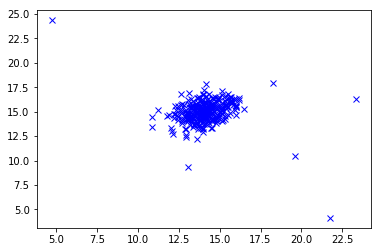

In [6]:
plt.plot(X[:,0],X[:,1],'bx')
plt.show()

## 1.获取训练集中样本特征的均值和方差 

In [7]:
def estimateGaussian(X , isCovariance):
    means = np.mean(X,axis=0)
    if isCovariance:#是否为协方差，协方差有表示特征之间的相关关系，协方差等于0，证明不相关
        sigma2 = (X-means).T@(X-means)/len(X)
    else:
        sigma2 = np.var(X,axis=0)
    return means,sigma2

In [9]:
means,sigma2 = estimateGaussian(X , isCovariance=True)
sigma2

array([[ 1.83263141, -0.22712233],
       [-0.22712233,  1.70974533]])

In [10]:
means,sigma2 = estimateGaussian(X , isCovariance=False)
sigma2

array([1.83263141, 1.70974533])

## 2.多元正态分布密度函数

𝑝(𝑥) = (2𝜋)1𝑛2|𝛴|1/2
𝑒𝑥𝑝 (− 1/2 (𝑥 − 𝜇)𝑇𝛴−1(𝑥 − 𝜇))

In [14]:
def gaussian(X,means,sigma2):
    if np.ndim(sigma2) == 1: #将一维数组转成方阵，若不是一维，获取对角线上的值
        sigma2 = np.diag(sigma2)
        
    X= X-means #x-u
    n = X.shape[1] #特征数
    
    first = np.power(2*np.pi,-n/2)*(np.linalg.det(sigma2)**(-0.5)) #det 求矩阵的行列式
    second = np.diag(X@np.linalg.inv(sigma2)@X.T) #inv 矩阵求逆 , diag 求对角线值
    p = first * np.exp(-0.5*second)
    p.shape
    p = p.reshape(-1,1) #转化二维数组

    return p
    

## 3.绘图 

In [15]:
def plotGaussian(X,means,sigma2):
    x = np.arange(0,30,0.5)
    y = np.arange(0,30,0.5)
    xx,yy = np.meshgrid(x,y) #画等高线必须转化成网格
    z = gaussian(np.c_[xx.ravel(),yy.ravel()],means,sigma2) #计算对应的高斯分布函数，np.c_ 用于连接两个矩阵，两维特征
    zz = z.reshape(xx.shape)
    plt.plot(X[:,0],X[:,1],'bx')
    contour_levels=[10**h for h in range(-20,0,3)] 
    plt.contour(xx,yy,zz,contour_levels)#绘制等高线

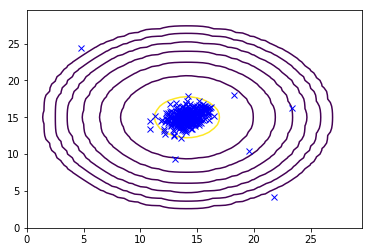

In [16]:
means,sigma2 = estimateGaussian(X , isCovariance=False)
plotGaussian(X,means,sigma2)

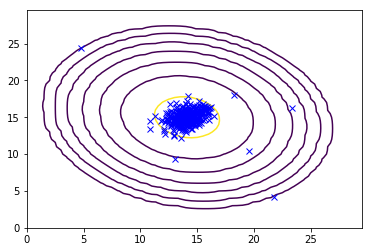

In [17]:
means,sigma2 = estimateGaussian(X , isCovariance=True)
plotGaussian(X,means,sigma2)

## 4.选取阈值 epsilon

In [19]:
def selectThreshold(yval,p):
    bestEpsilon = 0
    bestF1 = 0
    epsilons = np.linspace(min(p),max(p),1000)
    for e in epsilons:
        p_ = p < e
        tp = np.sum((yval==1)&(p_==1))
        fp = np.sum((yval==0)&(p_==1))
        fn = np.sum((yval==1)&(p_==0))
        prec = tp / (tp+fp) if(tp+fp) else 0
        rec = tp / (tp+fn) if(tp+fn) else 0
        F1_e = 2*prec*rec / (prec+rec) if (prec+rec) else 0
        if F1_e > bestF1:
            bestF1 = F1_e
            bestEpsilon = e
    return bestEpsilon,bestF1

In [26]:
means,sigma2 = estimateGaussian(X , isCovariance=False)
pval = gaussian(Xval,means,sigma2) #验证集的密度函数
bestEpsilon,bestF1 = selectThreshold(yval,pval)

In [27]:
bestEpsilon,bestF1 

(array([8.99985263e-05]), 0.8750000000000001)

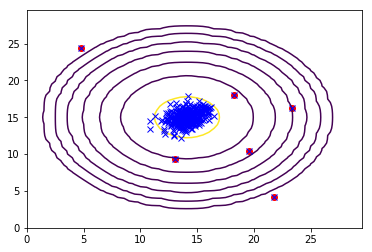

In [28]:
p = gaussian(X,means,sigma2)
anoms = np.array([X[i] for i in range(X.shape[0]) if p[i] <bestEpsilon]) #小于阈值的就是异常点
plotGaussian(X,means,sigma2)
plt.scatter(anoms[:,0],anoms[:,1],c='r',marker='o')

# 案例2：高维数据的异常检测

In [29]:
mat = sio.loadmat('ex8data2.mat')
X2 = mat['X']
Xval2,yval2 = mat['Xval'],mat['yval']
X2.shape

(1000, 11)

In [33]:
means,sigma2 = estimateGaussian(X2 , isCovariance=True)
pval = gaussian(Xval2,means,sigma2) #验证集的密度函数
bestEpsilon,bestF1 = selectThreshold(yval2,pval)
p = gaussian(X2,means,sigma2) 
anoms = [X2[i] for i in range(len(X2)) if p[i] <bestEpsilon] #小于阈值的就是异常点
len(anoms)

122